In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import signal

# append path for loading own packages
import sys
sys.path.append("../packages")

import auxiliary as aux
import edges
import func2areamap

1.0
CPU times: user 28.3 s, sys: 84 ms, total: 28.3 s
Wall time: 28.2 s
Original: (256, 256)
Convoluted: (256, 256)
Sum unconvoluted edge: 32768.0
Sum convoluted edge: 32767.999999999993


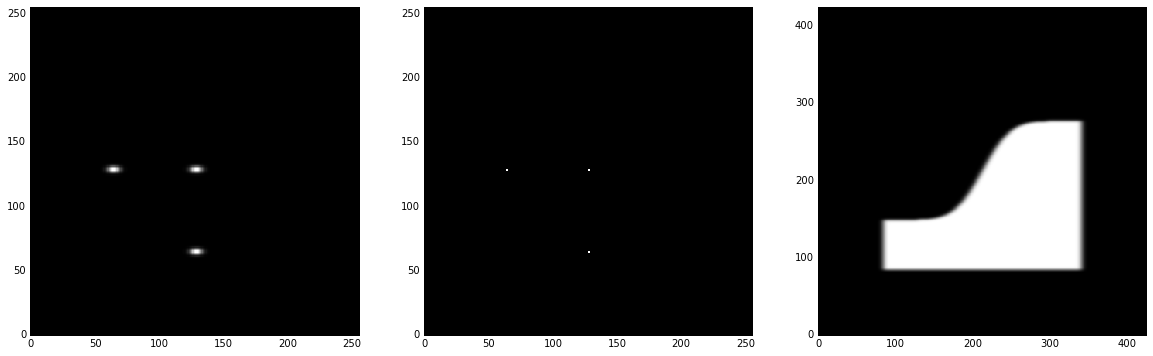

In [3]:
# Define range of primary picture
xmin1 = -1.
xmax1 = 1

# Define shaply edged 2d density
f = lambda x : edges.make_erf_edge(0.5, 1)(x) - 0.5

# Define range of convolution kernel
xmin2 = xmin1 * 0.5
xmax2 = xmax1 * 0.5

# Define "width" of edge broadening in x and y direction
sigmax = (xmax1-xmin1)*0.01
sigmay = (xmax1-xmin1)*0.005

# Define resolution
res1 = 256
res2 = res1*(xmax2-xmin2)//(xmax1-xmin2)

# Define 1d coordinate array of primary picture
x1 = np.linspace(xmin1, xmax1, res1)
ff = func2areamap.func2areamap(x1, x1, f(x1)).T

# Define primary picture of scattered 1 px spots
aa = np.zeros(shape=(res1, res1))
aa[res1//2, res1//2] = 1
aa[res1//4, res1//2] = 1
aa[res1//2, res1//4] = 1

# Define 1d coordinate array of convolution kernel
x2 = np.linspace(xmin2, xmax2, res2)

# Make 2d coordinate arrays of convolution kernel
xx2, yy2 = np.meshgrid(x2, x2)

# Make convolution kernel
bb = np.exp(-xx2**2/(2*sigmax**2) -yy2**2/(2*sigmay**2))
bb = bb/bb.sum()
print(bb.sum())

# Convolve pictures
cc = signal.convolve2d(aa,bb, mode='same')
%time dd = signal.convolve2d(ff,bb)

# Plot
fig = plt.figure(figsize=(20,6))
sub1 = fig.add_subplot(1, 3, 1)
aux.imshow(cc)
sub2 = fig.add_subplot(1, 3, 2)
aux.imshow(aa)
sub3 = fig.add_subplot(1, 3, 3)
aux.imshow(dd)

print("Original: {}".format(aa.shape))
print("Convoluted: {}".format(cc.shape))

print("Sum unconvoluted edge: {}".format(ff.sum()))
print("Sum convoluted edge: {}".format(dd.sum()))

Shape of smoothed edge, valid: (241, 241)
Shape of sharp edge: (256, 256)
Smoothing kernel resolution: 16
(256, 256)


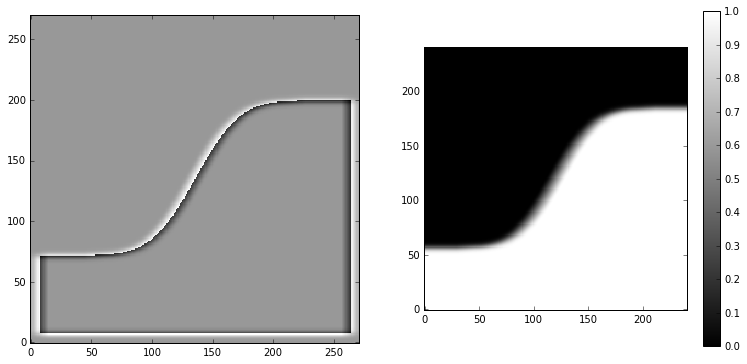

In [4]:
xmin_tile = -0.1
xmax_tile = 0.1
res_tile  = 256
x_tile    = np.linspace(xmin_tile, xmax_tile, res_tile)
xx_tile, yy_tile = np.meshgrid(x_tile, x_tile)

f = lambda x : edges.make_erf_edge(0.05, 0.1)(x) - 0.05

edge_tile = func2areamap.func2areamap(x_tile, x_tile, f(x_tile))

sigmax = 0.002
sigmay = 0.01

res_kernel = 16
xmin_kernel = xmin_tile*res_kernel/res_tile
xmax_kernel = xmax_tile*res_kernel/res_tile
x_kernel = np.linspace(xmin_kernel, xmax_kernel, res_kernel)
xx_kernel, yy_kernel = np.meshgrid(x_kernel, x_kernel)
kernel = np.exp(- xx_kernel**2/(2*sigmax**2) - yy_kernel**2/(2*sigmay**2))
#kernel = np.zeros(shape=xx_kernel.shape)
#kernel[res_kernel//2, res_kernel//2] = 1
kernel = kernel/kernel.sum()

smooth_edge_tile = {}
smooth_edge_tile['full'] = signal.convolve2d(edge_tile, kernel, mode='full')
smooth_edge_tile['valid'] = signal.convolve2d(edge_tile, kernel, mode='valid')

print('Shape of smoothed edge, valid: {}'.format(smooth_edge_tile['valid'].shape))
print('Shape of sharp edge: {}'.format(edge_tile.shape))
print('Smoothing kernel resolution: {}'.format(res_kernel))

helper = np.zeros(shape=smooth_edge_tile['full'].shape)
helper[res_kernel//2:edge_tile.shape[0]+res_kernel//2,\
       res_kernel//2:edge_tile.shape[1]+res_kernel//2] = edge_tile

print(edge_tile.shape)

fig = plt.figure(figsize=(20, 6))

sub1 = fig.add_subplot(1, 3, 1)
aux.imshow((smooth_edge_tile['full']-helper).T)

sub2 = fig.add_subplot(1, 3, 2)
aux.imshow((smooth_edge_tile['valid']).T)

#aux.imshow((smooth_edge_tile).T)
#aux.imshow((helper).T)
plt.colorbar()

(542, 271)


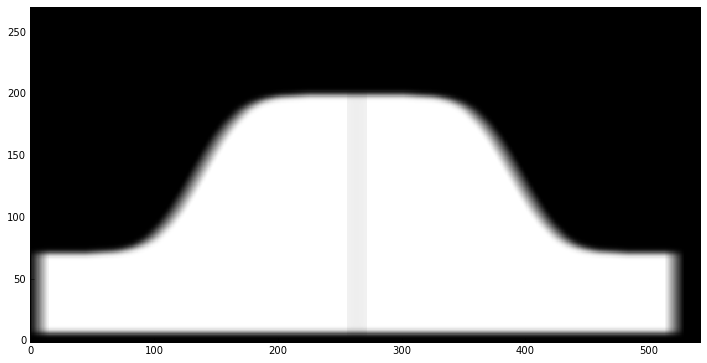

In [5]:
feature = np.zeros(shape=(2*smooth_edge_tile['full'].shape[0], smooth_edge_tile['full'].shape[1]))
print(feature.shape)

feature[0:smooth_edge_tile['full'].shape[0], :] += smooth_edge_tile['full'][:,:]
feature[2+smooth_edge_tile['full'].shape[0]-res_kernel:2+2*smooth_edge_tile['full'].shape[0]-res_kernel, :] += smooth_edge_tile['full'][::-1,:]
#feature[edge_tile.shape[0]+res_kernel//2:feature.shape[0]-res_kernel//2, :] += smooth_edge_tile[::-1,:]

fig = plt.figure(figsize=(20,6))
aux.imshow(feature.T)

In [6]:
def smooth(a, b):
    return signal.convolve2d(a, b, mode='valid')

def pad(a, nx, ny):
    is_nx = a.shape[0]
    is_ny = a.shape[1]
    
    pad_nx = nx - is_nx
    pad_ny = ny - is_ny
    
    left_pad_nx = pad_nx//2
    right_pad_nx = (pad_nx+1)//2
    bottom_pad_ny = pad_ny//2
    top_pad_ny = (pad_ny+1)//2
    
    left_pad_ix = 0
    right_pad_ix = is_nx + left_pad_nx
    bottom_pad_iy = 0
    top_pad_iy = is_ny + bottom_pad_ny
    
    original_ix = left_pad_nx
    original_iy = bottom_pad_ny
    
    t = np.zeros(shape=(nx, ny))
    t[original_ix:original_ix + is_nx, original_iy:original_iy + is_ny] = a
    for ix in range(left_pad_nx):
        t[ix, original_iy:original_iy + is_ny] = a[0, :]
    for ix in range(right_pad_nx):
        t[ix + right_pad_ix, original_iy:original_iy + is_ny] = a[-1, :]
    for iy in range(bottom_pad_ny):
        t[original_ix:original_ix + is_nx, iy] = a[:, 0]
    for iy in range(top_pad_ny):
        t[original_ix:original_ix + is_nx, iy + top_pad_iy] = a[:, -1]
    t[left_pad_ix:left_pad_nx, bottom_pad_iy:bottom_pad_ny] = a[0, 0]
    t[right_pad_ix:right_pad_nx+right_pad_ix, bottom_pad_iy:bottom_pad_ny] = a[-1, 0]
    t[left_pad_ix:left_pad_nx, top_pad_iy:top_pad_ny+top_pad_iy] = a[0, -1]
    t[right_pad_ix:right_pad_nx+right_pad_ix, top_pad_iy:top_pad_ny+top_pad_iy] = a[-1, -1]
    return t

(100, 100)


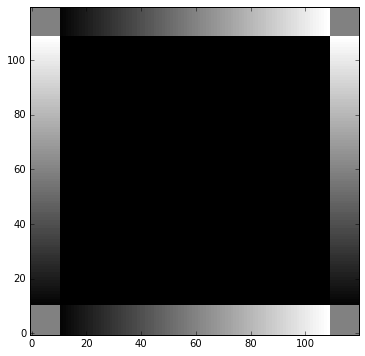

In [12]:
s = np.zeros(shape=(100, 100))
s[:, 0] = np.linspace(1, 100, 100)
s[:, -1] = np.linspace(1, 100, 100)
s[0, :] = np.linspace(1, 100, 100)
s[-1, :] = np.linspace(1, 100, 100)
s[0, 0] = 50
s[0, -1] = 50
s[-1, 0] = 50
s[-1, -1] = 50
print(s.shape)

p = pad(s, 120, 120)

fig = plt.figure(figsize=(20,6))
sub1 = fig.add_subplot(1,3,1)
aux.imshow(p.T)

Shape a: (256, 256), shape b: (16, 16)
Sum a: 32768.0, sum p: 32703.999999999996


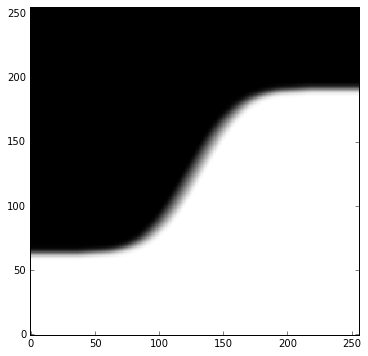

In [8]:
a = edge_tile
b = kernel

print('Shape a: {}, shape b: {}'.format(a.shape, b.shape))

s = smooth(a, b)
p = pad(s, a.shape[0], a.shape[1])

print('Sum a: {}, sum p: {}'.format(a.sum(), p.sum()))

fig = plt.figure(figsize=(20,6))
sub1 = fig.add_subplot(1,3,1)
aux.imshow(p.T)

In [9]:
def symm_feat(a):
    f = np.zeros(shape=(2*a.shape[0], a.shape[1]))
    f[0:a.shape[0], :] = a
    f[a.shape[0]:f.shape[0], :] = a[::-1, :]
    return f

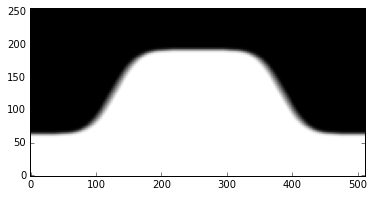

In [10]:
f = symm_feat(p)

aux.imshow(f.T)

In [11]:
def make_trafo2featid(**kwargs):
    xpmin = kwargs['xpmin']
    xpmax = kwargs['xpmax']
    xpres = kwargs['xpres']
    ypmin = kwargs['ypmin']
    ypmax = kwargs['ypmax']
    ypres = kwargs['ypres']
    pitch = kwargs['pitch']
    
    featidx = lambda xp : ((xp-xpmin)*xpres)//(xpmax-xpmin)
    featidy = lambda yp : ((yp%pitch-ypmin)*ypres)//(ypmax-ypmin)
    
    f = lambda xp, yp, zp : (featidx(xp), featidy(yp))
    return f

def make_density(feat, trafo2featid):
    f = lambda xp, yp, zp : feat[ trafo2featid(xp, yp, zp)[0].astype(np.int),\
                                   trafo2featid(xp, yp, zp)[1].astype(np.int)]
    return f

feat = f
trafo2featid = make_trafo2featid(xpmin=-1., xpmax=1., xpres=512, ypmin=0., ypmax=10., ypres=256, pitch=2)
density = make_density(feat, trafo2featid)

x = np.linspace(0., 10, 100)
y = np.linspace(0., 10, 50)
xx, yy = np.meshgrid(x, y)

trafo2featid(1., 1., 1.)
d = density(xx, yy, 0.)

IndexError: index 514 is out of bounds for axis 0 with size 512